## Using pre-trained NN

In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from scipy.misc import imread, imsave, imresize
from lasagne.utils import floatX

# Model Zoo
* https://github.com/Lasagne/Recipes/tree/master/modelzoo
* More models within the community
* Pick model, copy init, download weights
* Here we proceed with vgg16

In [ ]:
!wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl

In [78]:
# copyright: see http://www.robots.ox.ac.uk/~vgg/research/very_deep/


from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.nonlinearities import softmax


def build_model():
    net = {}
    net['input'] = InputLayer((None, 3, 224, 224))
    net['conv1_1'] = ConvLayer(
        net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(
        net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(
        net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = ConvLayer(
        net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(
        net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = ConvLayer(
        net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = ConvLayer(
        net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_3'], 2)
    net['conv4_1'] = ConvLayer(
        net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = ConvLayer(
        net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = ConvLayer(
        net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_3'], 2)
    net['conv5_1'] = ConvLayer(
        net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = ConvLayer(
        net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = ConvLayer(
        net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['pool5'] = PoolLayer(net['conv5_3'], 2)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5)
    net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=4096)
    net['fc7_dropout'] = DropoutLayer(net['fc7'], p=0.5)
    net['fc8'] = DenseLayer(
        net['fc7_dropout'], num_units=1000, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc8'], softmax)

    return net

In [79]:
#classes' names are stored here
file = open('classes.pkl', 'rb')
# print(file.readline())

classes = pickle.load(file)
#for example, 10th class is ostrich:
print(classes[9])

ostrich, Struthio camelus


You have to implement two functions in the cell below.

Preprocess function should take the image with shape (w, h, 3) and transform it into a tensor with shape (1, 3, 224, 224). Without this transformation, vgg19 won't be able to digest input image. 
Additionally, your preprocessing function have to rearrange channels RGB -> BGR and subtract mean values from every channel.

In [80]:
MEAN_VALUES = np.array([104, 117, 123])
IMAGE_W = 224

def preprocess(img):
    img = img[:, :, :: -1]
   
    img = img - MEAN_VALUES
    img = np.transpose(img, (2, 0, 1))[None]
    return img

def deprocess(img):
    img = img.reshape(img.shape[1:]).transpose((1, 2, 0))
    for i in range(3):
        img[:,:, i] += MEAN_VALUES[i]
    return img[:, :, :: -1].astype(np.uint8)

img = (np.random.rand(IMAGE_W, IMAGE_W, 3) * 256).astype(np.uint8)
print(np.linalg.norm(deprocess(preprocess(img)) - img))

0.0


If your implementation is correct, the number above will be small, because deprocess function is the inverse of preprocess function

### Deploy the network

In [81]:
vgg_net = build_model()

In [82]:
with open('vgg16.pkl', 'rb') as f:
    weights = pickle.load(f, encoding='latin1')

In [84]:
layers = lasagne.layers.get_all_layers(vgg_net['prob'])
lasagne.layers.set_all_param_values(layers, weights['param values'] )

In [88]:
input_X = T.tensor4("X")
output = lasagne.layers.get_output(vgg_net['prob'], input_X, deterministic=True)
prob = theano.function([input_X], output) 

### Sanity check
Давайте проверим, что загруженная сеть работает. Для этого мы скормим ей картину альбатроса и проверим, что она правильно его распознаёт

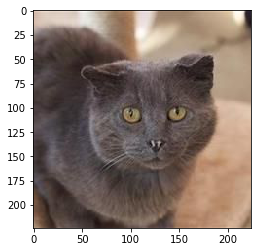

top-5 classes are:
0.104962	lynx
0.067698	Egyptian cat
0.061867	cougar
0.044958	tabby
0.032771	Persian cat


In [89]:
img = imread('cat.jpg')
plt.imshow(img)
plt.show()

p = prob(preprocess(img))
# print(p.shape, my_p.shape)
labels = p.ravel().argsort()[-1:-6:-1]
print('top-5 classes are:')
for l in labels:
    print('%3f\t%s' % (p.ravel()[l], classes[l].split(',')[0]))

# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [ ]:
!wget https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1 -O data.zip
!unzip data.zip

because in my computer forwarding images to pool5 layer would took around 1 day, I used my friends processed data, for train and test in which images are forwarded to the pool5 layer in vgg_16

In [2]:
processed_img = open('processed_train.pkl', 'rb')

In [3]:
data = []
while True:
    try:
        example = pickle.load(processed_img)
    except EOFError:
        break
    data.append(example)

In [4]:
X = []
Y = []
for datum in data:
    X.append(datum['X'])
    Y.append(datum['y'])

In [5]:
Y[23000]

True

In [6]:
np.array(X[100]).shape

(1, 512, 7, 7)

In [7]:
X = np.stack(X, axis = 1)
X=X[0]
y = []
for index in range(len(Y)):
    if Y[index] == True:
        y.append(1)
    else:
        y.append(0)
Y= np.array(y)

In [8]:
X.shape, Y.shape, Y[25]

((25000, 512, 7, 7), (25000,), 0)

In [9]:
from sklearn.cross_validation import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2)

/home/hp/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
X_train.shape, y_train.shape

((20000, 512, 7, 7), (20000,))

In [61]:
from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.nonlinearities import softmax


# my network above vgg pool5 layer
net = {}
net = InputLayer((None, 512, 7, 7))
net = DenseLayer(net, num_units=10)
net = DropoutLayer(net, p=0.5)
net = DenseLayer(net, num_units=2)
net = NonlinearityLayer(net, softmax)

In [62]:
target_y = T.vector("target Y integer",dtype='int64')
input_X = T.tensor4("X")
input_shape = [None,512,7,7]
output = lasagne.layers.get_output(net, input_X, deterministic=True)
output_l = lasagne.layers.get_output(net, input_X)
all_weights = lasagne.layers.get_all_params(net)

In [63]:
#Mean categorical crossentropy as a loss function - similar to logistic loss but for multiclass targets
loss = lasagne.objectives.categorical_crossentropy(output_l,target_y).mean()

#prediction accuracy
accuracy = lasagne.objectives.categorical_accuracy(output,target_y).mean()

#This function computes gradient AND composes weight updates just like you did earlier
updates_sgd = lasagne.updates.adadelta(loss, all_weights,learning_rate=0.3, rho=0.9)

In [64]:
#function that computes loss and updates weights
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)

#function that just computes accuracy
accuracy_fun = theano.function([input_X,target_y],accuracy)

In [65]:
def iterate_minibatches(inputs, targets, batchsize):
    assert len(inputs) == len(targets)
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield inputs[excerpt], targets[excerpt]

In [66]:
import time

num_epochs = 15 #amount of passes through the data
loss = []
batch_size = 50 #number of samples processed at each function call

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    loss.append(train_err / train_batches)

Epoch 1 of 15 took 3.101s
  training loss (in-iteration):		0.318494
  train accuracy:		95.07 %
Epoch 2 of 15 took 2.871s
  training loss (in-iteration):		0.235304
  train accuracy:		98.51 %
Epoch 3 of 15 took 2.870s
  training loss (in-iteration):		0.218755
  train accuracy:		98.79 %
Epoch 4 of 15 took 2.937s
  training loss (in-iteration):		0.192902
  train accuracy:		99.14 %
Epoch 5 of 15 took 3.083s
  training loss (in-iteration):		0.191769
  train accuracy:		99.35 %
Epoch 6 of 15 took 3.061s
  training loss (in-iteration):		0.179208
  train accuracy:		99.51 %
Epoch 7 of 15 took 2.911s
  training loss (in-iteration):		0.172661
  train accuracy:		99.57 %
Epoch 8 of 15 took 3.376s
  training loss (in-iteration):		0.173649
  train accuracy:		99.64 %
Epoch 9 of 15 took 4.173s
  training loss (in-iteration):		0.169052
  train accuracy:		99.71 %
Epoch 10 of 15 took 3.281s
  training loss (in-iteration):		0.164537
  train accuracy:		99.75 %
Epoch 11 of 15 took 2.962s
  training loss (in-it

its strange, but when I use more complex network, I will get higher score on validation, but on my submission it will decrease my score, so i kept my net small and simple

In [67]:
accuracy_fun(X_val, y_val) * 100

98.440000000000012

now lets predict on kaggle test data, because your cat vs dog competition is closed for submission, I submitted to cat vs dogs kernels edition, I will include screenshoot with my score within the folder

In [68]:
processed_img = open('processed_test.pkl', 'rb')

In [69]:
data = []
while True:
    try:
        example = pickle.load(processed_img)
    except EOFError:
        break
    data.append(example)

In [70]:
X = []
Y = []
for datum in data:
    X.append(datum['X'])
    Y.append(datum['id'])

In [71]:
X = np.stack(X, axis = 1)
X=X[0]
Y= np.array(Y)

In [73]:
my_prob = theano.function([input_X], output) 

In [74]:
prediction = my_prob(X)

In [75]:
prediction.shape, Y.shape

((12500, 2), (12500,))

In [77]:
import csv
with open('predictions.csv','w') as f:
    writer = csv.writer(f)
    writer.writerow(('id','label'))
    for i in range(len(prediction)):
        writer.writerow((Y[i],prediction[i][0]))